# Preparation

In [9]:
%cd 'drive/My Drive/wheat_growth'

/content/drive/My Drive/wheat_growth


In [10]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai
!pip install -q efficientnet-pytorch

In [4]:
import random
import os
import gc
import datetime
import random
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage
from fastai.vision.all import *
from efficientnet_pytorch import EfficientNet

In [5]:
random.seed(12)
np.random.seed(12)
set_seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [11]:
main_df = pd.read_csv('pseudo_label.csv')
sub_df = pd.read_csv('SampleSubmission.csv')
main_df.head()

,UID,growth_stage
0,NVGUOzWu,6.393614
1,1IYVvHwA,4.485182
2,8OEdWwmU,3.126373
3,oc5iO04j,6.761811
4,A60rOyP9,6.929127


In [12]:
tfms_res50 = setup_aug_tfms([Rotate(max_deg=15, p=1.),
                            RandomResizedCrop(p=1., size=256),
                            Brightness(max_lighting=1.0, p=0.4),
                            CropPad(size=256),
                            Zoom(max_zoom=1.0, p=0.2),
                            Warp(magnitude=0.2, p=0.2),
                            ])

# Image Augmentation used for Densenet201 and  lr_max = slice (10e-7, 10e-6) with 40 epochs
tfms_dn201 = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                            CropPad(size=256),
                            Zoom(max_zoom=1.5, p=0.5),
                            Warp(magnitude=0.5, p=0.5),
                            ])

# Image Augmentation used for Vgg16_bn and lr_max = slice (10e-6) with 40 epochs
tfms_vgg16 = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                    CropPad(size=256),
                    Zoom(max_zoom=1.1, p=0.5),
                    Warp(magnitude=0.2, p=0.5),
                    ])

tfms_en = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
                            CropPad(size=256),
                            Zoom(max_zoom=1.1, p=0.5),
                            Warp(magnitude=0.2, p=0.2),
                            ])


In [13]:
loss_func = LabelSmoothingCrossEntropy()

# VGG16

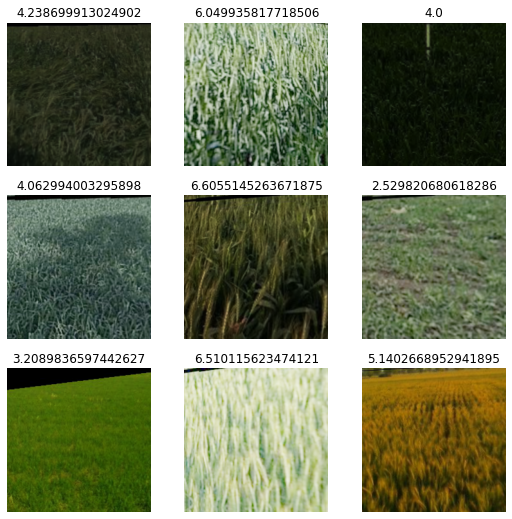

In [15]:
dls_vgg = ImageDataLoaders.from_df(main_df,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_vgg16,
                               )

dls_vgg.show_batch()

In [ ]:
learn_vgg = cnn_learner(dls_vgg, vgg16_bn, metrics=rmse, pretrained=True).to_fp16()
learn_vgg.fine_tune(70)

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=1.3182567499825382e-06)

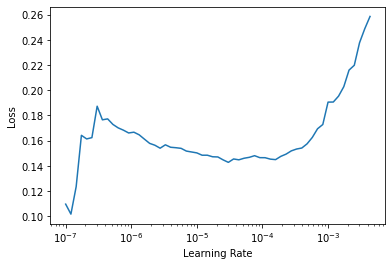

In [ ]:
learn_vgg.unfreeze()
learn_vgg.lr_find()

In [ ]:
learn_vgg.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.147513,0.090906,0.301506,01:33
1,0.156206,0.096102,0.310002,01:33
2,0.156609,0.089255,0.298756,01:33
3,0.156138,0.092635,0.304359,01:33
4,0.156259,0.092528,0.304184,01:33
5,0.153394,0.091141,0.301895,01:34
6,0.149548,0.090083,0.300138,01:33
7,0.160254,0.091993,0.303303,01:33
8,0.155926,0.088846,0.298070,01:34
9,0.160086,0.088597,0.297652,01:34


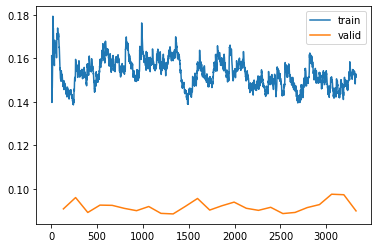

In [ ]:
learn_vgg.recorder.plot_loss()

In [ ]:
ss_vgg = sub_df
tdl_vgg = learn_vgg.dls.test_dl(ss_vgg)
pred_vgg = learn_vgg.tta(dl=tdl_vgg)

In [ ]:
ss_vgg['growth_stage'] = pred_vgg[0].numpy()
ss_vgg.head()

,UID,growth_stage
0,F3LbWkZq,4.204102
1,6P4wLVzI,3.788086
2,Tn6HIrdS,2.726685
3,EYM5R1TK,4.146484
4,fkcevlA0,5.153564


In [ ]:
now = datetime.now()
file_name = 'models/pl_VGG16_' + now.strftime('%d_%H%M') + '.pkl'
learn_vgg.export(file_name)

In [ ]:
now = datetime.now()
file_name = 'sub/pl_VGG16_' + now.strftime('%d_%H%M') + '.csv'
ss_vgg.to_csv(file_name, index=False)

# ResNet50

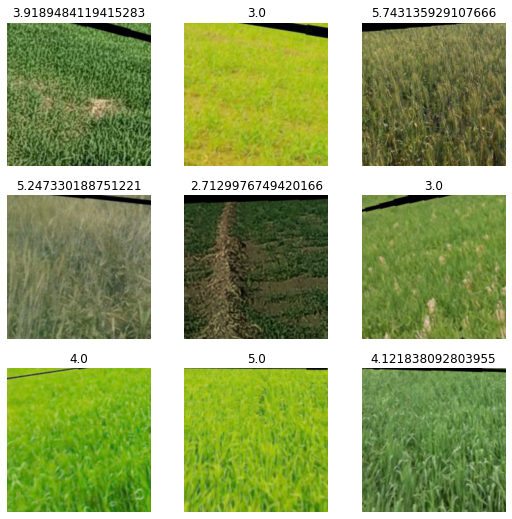

In [ ]:
dls_res50 = ImageDataLoaders.from_df(main_df,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_res50,
                               )

dls_res50.show_batch()

In [ ]:
learn_res50 = cnn_learner(dls_res50, resnet50, metrics=rmse, pretrained=True).to_fp16()
learn_res50.fine_tune(70)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,_rmse,time
0,12.905240,4.208706,2.051513,01:01


epoch,train_loss,valid_loss,_rmse,time
0,3.750185,0.718089,0.847401,01:06
1,2.944099,0.713194,0.844508,01:04
2,2.477542,0.463830,0.681051,01:05
3,2.104442,0.514008,0.716943,01:05
4,1.789181,0.304646,0.551947,01:05
5,1.609733,0.486225,0.697299,01:05
6,1.337333,0.319827,0.565533,01:06
7,1.165616,0.348821,0.590611,01:05
8,1.000545,0.196331,0.443093,01:05
9,0.924397,0.363821,0.603176,01:05


In [ ]:
learn_res50.recorder.plot_loss()

In [ ]:
learn_res50.unfreeze()
learn_res50.lr_find()

In [ ]:
learn_res50.fit_one_cycle(25, lr_max=slice(10e-7, 10e-5))

In [ ]:
learn_res50.recorder.plot_loss()

In [ ]:
ss_res50 = sub_df
tdl_res50 = learn_res50.dls.test_dl(ss_res50)
pred_res50 = learn_res50.tta(dl=tdl_res50)

In [ ]:
ss_res50['growth_stage'] = pred_res50[0].numpy()
ss_res50.head()

In [ ]:
now = datetime.now()
file_name = 'models/pl_ResNet50_' + now.strftime('%d_%H%M') + '.pkl'
learn_res50.export(file_name)

In [ ]:
now = datetime.now()
file_name = 'sub/pl_ResNet50_' + now.strftime('%d_%H%M') + '.csv'
ss_res50.to_csv(file_name, index=False)

# DenseNet201

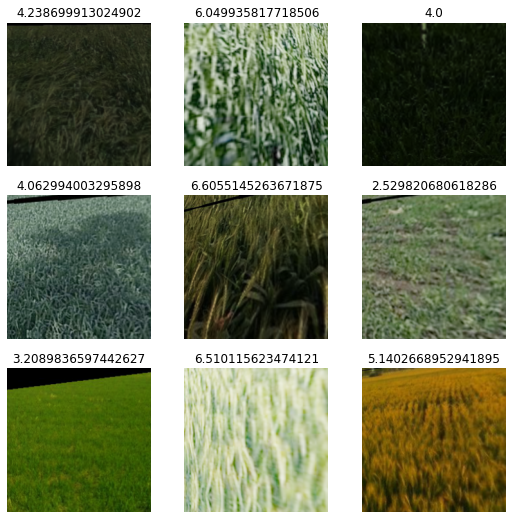

In [ ]:
dls_dn201 = ImageDataLoaders.from_df(main_df,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms_dn201,
                               )

dls_dn201.show_batch()

In [ ]:
learn_dn201 = cnn_learner(dls_dn201, densenet201, metrics=rmse, pretrained=True).to_fp16()
learn_dn201.fine_tune(50)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,_rmse,time
0,12.603182,2.987089,1.728320,01:21


epoch,train_loss,valid_loss,_rmse,time
0,3.375807,0.549140,0.741040,01:39
1,2.930791,0.488243,0.698744,01:37
2,2.392973,0.600929,0.775196,01:37
3,2.122991,0.405059,0.636443,01:36
4,1.812519,0.429020,0.654996,01:36
5,1.454009,0.329320,0.573864,01:36
6,1.247001,0.390339,0.624771,01:36
7,1.084692,0.238908,0.488782,01:35
8,0.883226,0.283683,0.532619,01:36
9,0.763289,0.169131,0.411255,01:35


SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=6.309573450380412e-07)

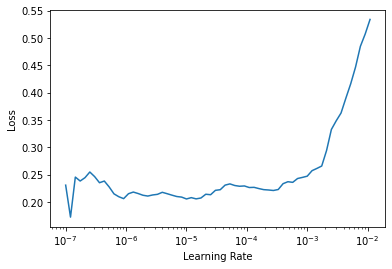

In [ ]:
learn_dn201.unfreeze()
learn_dn201.lr_find()

In [ ]:
learn_dn201.fit_one_cycle(25, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.209709,0.082485,0.287202,01:38
1,0.225238,0.082196,0.286699,01:38
2,0.233098,0.081668,0.285776,01:38
3,0.212765,0.082252,0.286796,01:38
4,0.222566,0.082454,0.287148,01:38
5,0.219423,0.084493,0.290676,01:38
6,0.232895,0.087947,0.296559,01:38
7,0.226832,0.085705,0.292754,01:37
8,0.226843,0.081893,0.286169,01:38
9,0.221082,0.084073,0.289953,01:38


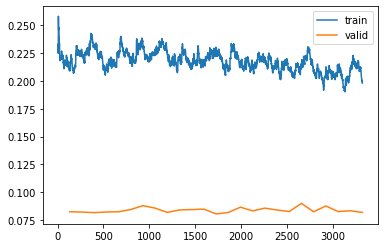

In [ ]:
learn_dn201.recorder.plot_loss()

In [ ]:
ss_dn201 = sub_df
tdl_dn201 = learn_dn201.dls.test_dl(ss_dn201)
pred_dn201 = learn_dn201.tta(dl=tdl_dn201)

In [ ]:
ss_dn201['growth_stage'] = pred_dn201[0].numpy()
ss_dn201.head()

,UID,growth_stage
0,F3LbWkZq,4.245605
1,6P4wLVzI,3.899536
2,Tn6HIrdS,2.823364
3,EYM5R1TK,4.096924
4,fkcevlA0,4.794189


In [ ]:
now = datetime.now()
file_name = 'models/pl_DenseNet201_' + now.strftime('%d_%H%M') + '.pkl'
learn_dn201.export(file_name)

In [ ]:
now = datetime.now()
file_name = '/content/drive/My Drive/wheat/sub/pl_DenseNet201_' + now.strftime('%d_%H%M') + '.csv'
ss_dn201.to_csv(file_name, index=False)

# EfficientNet-B0

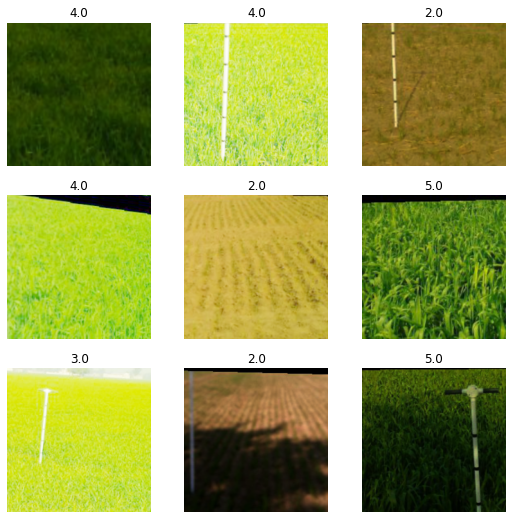

In [ ]:
dls_en = ImageDataLoaders.from_df(main_df,
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage',
                               item_tfms=Resize(224), 
                               y_block=RegressionBlock,
                               batch_tfms = tfms_en,
                               )

dls_en.show_batch()

In [ ]:
arch = EfficientNet.from_pretrained('efficientnet-b0', advprop=True)
arch._fc = nn.Linear(1280, dls_en.c)

Loaded pretrained weights for efficientnet-b0


In [ ]:
learn_en = Learner(dls_en, arch, metrics=rmse)
learn_en.fine_tune(70)

epoch,train_loss,valid_loss,_rmse,time
0,4.686488,120.233406,10.965098,00:20


epoch,train_loss,valid_loss,_rmse,time
0,0.857581,7.586995,2.754450,00:19
1,0.714606,4.891273,2.211622,00:19
2,0.617140,1.270179,1.127022,00:19
3,0.558545,0.743490,0.862259,00:19
4,0.488563,0.535361,0.731683,00:19
5,0.458600,1.455762,1.206550,00:19
6,0.478510,1.298791,1.139645,00:19
7,0.471770,0.519835,0.720996,00:19
8,0.432623,0.402603,0.634510,00:19
9,0.430637,0.662293,0.813814,00:19


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.3182567499825382e-06)

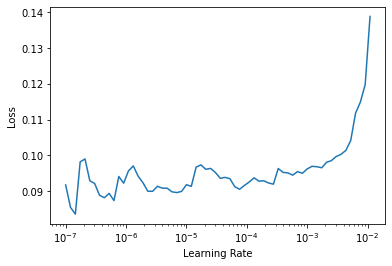

In [ ]:
learn_en.unfreeze()
learn_en.lr_find()

In [ ]:
learn_en.fit_one_cycle(25, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.102786,0.242058,0.491994,00:19
1,0.100216,0.242361,0.492302,00:19
2,0.091433,0.238640,0.488508,00:19
3,0.091386,0.251775,0.501772,00:19
4,0.094102,0.249165,0.499164,00:19
5,0.092601,0.248498,0.498496,00:19
6,0.091919,0.245140,0.495116,00:19
7,0.094122,0.237283,0.487117,00:19
8,0.095293,0.259810,0.509716,00:19
9,0.096229,0.266677,0.516407,00:20


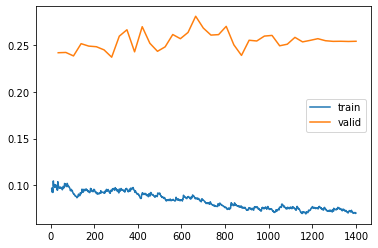

In [ ]:
learn_en.recorder.plot_loss()

In [ ]:
ss_en = sub_df
tdl_en = learn_en.dls.test_dl(ss_en)
pred_en = learn_en.tta(dl=tdl_en)

In [ ]:
ss_en['growth_stage'] = pred_en[0].numpy()
ss_en.head()

,UID,growth_stage
0,F3LbWkZq,4.172538
1,6P4wLVzI,4.051332
2,Tn6HIrdS,2.900674
3,EYM5R1TK,4.073316
4,fkcevlA0,6.384021


In [ ]:
now = datetime.now()
file_name = 'models/pl_EfficientNet_' + now.strftime('%d_%H%M') + '.pkl'
learn_en.export(file_name)

In [ ]:
now = datetime.now()
file_name = 'sub/pl_EfficientNet_' + now.strftime('%d_%H%M') + '.csv'
ss_en.to_csv(file_name, index=False)

# Ensembles

In [ ]:
vgg = pd.read_csv('sub/pl_VGG16_04_1716.csv', names=('UID', 'vgg'))
res = pd.read_csv('sub/pl_ResNet50_04_2044.csv', names=('UID', 'res'))
dn = pd.read_csv('sub/DenseNet201_04_1007.csv', names=('UID', 'dn'))
en = pd.read_csv('sub/EfficientNet_04_1104.csv', names=('UID', 'en'))

In [ ]:
model_list = [dn, en]

merged = pd.merge(vgg, res, on='UID')


for model in model_list:
    merged = pd.merge(merged, model, on='UID')

merged = merged.drop(index=[0])
merged = merged.reset_index()
merged.head()

,index,UID,vgg,res,dn,en
0,1,F3LbWkZq,4.2041016,4.44458,4.3326416,4.172538
1,2,6P4wLVzI,3.788086,3.907959,3.7016602,4.0513315
2,3,Tn6HIrdS,2.7266846,2.659668,2.7630615,2.9006736
3,4,EYM5R1TK,4.1464844,4.1706543,4.0184326,4.0733156
4,5,fkcevlA0,5.1535645,5.2841797,5.3146973,6.3840213


In [ ]:
name_list = ['vgg', 'res', 'dn', 'en']

for name in name_list:
    merged[name] = merged[name].astype(float)

In [ ]:
merged['pred'] = (
    merged.vgg * 0.3
    + merged.res * 0.3
    + merged.dn * 0.2
    + merged.en * 0.2
)

merged.head()

,index,UID,vgg,res,dn,en,pred
0,1,F3LbWkZq,4.204102,4.444580,4.332642,4.172538,4.295640
1,2,6P4wLVzI,3.788086,3.907959,3.701660,4.051331,3.859412
2,3,Tn6HIrdS,2.726685,2.659668,2.763062,2.900674,2.748653
3,4,EYM5R1TK,4.146484,4.170654,4.018433,4.073316,4.113491
4,5,fkcevlA0,5.153564,5.284180,5.314697,6.384021,5.471067


In [ ]:
counter = 0

In [ ]:
now = datetime.now()
counter += 1
file_name = 'sub/pl_ensemble_' + now.strftime('%d_%H%M') + '_ver' + str(counter) + '.csv'

merged[['UID', 'pred']].to_csv(file_name, index=False)